In [1]:
import SimpleITK as sitk
# from downloaddata import fetch_data as fdata
%matplotlib inline
from extensies import gui
from extensies import registration_gui as rgui
from extensies import preprocessing as ppcs
from extensies import normalization 
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os

import re 
OUTPUT_DIR = 'output'

In [2]:
df_images = pd.read_csv('../data/ProstateX-TrainingLesionInformationv2/ProstateX-TrainingLesionInformationv2/ProstateX-Images-Train.csv')
df_findings = pd.read_csv('../data/ProstateX-TrainingLesionInformationv2/ProstateX-TrainingLesionInformationv2/ProstateX-Findings-Train.csv')

# Visualisation

In [3]:
fixed_series_filenames = sitk.ImageSeriesReader_GetGDCMSeriesFileNames(pcs.get_path('ProstateX-0000', 't2tsetra', '../../data/PROSTATEx'))
moving_series_filenames = sitk.ImageSeriesReader_GetGDCMSeriesFileNames(pcs.get_path('ProstateX-0000', 'adc', '../../data/PROSTATEx'))

fixed_image = sitk.ReadImage(fixed_series_filenames, sitk.sitkFloat32)
moving_image = sitk.ReadImage(moving_series_filenames, sitk.sitkFloat32)
moving_imageK = sitk.ReadImage('../../data/Ktrans/ProstateX-0001/ProstateX-0001-Ktrans.mhd', sitk.sitkFloat64)

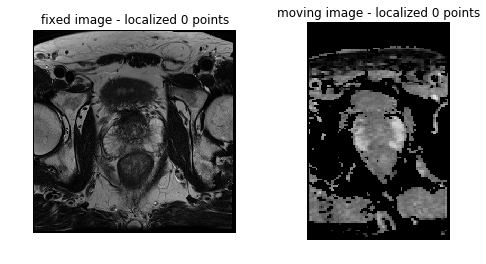

In [4]:
initial_transform = sitk.CenteredTransformInitializer(fixed_image, 
                                                      moving_image, 
                                                      sitk.Euler3DTransform(), 
                                                      sitk.CenteredTransformInitializerFilter.GEOMETRY)

gui.RegistrationPointDataAquisition(fixed_image, moving_image, figure_size=(8,4), known_transformation=initial_transform);

# Rotation

In [6]:
fixed_image.GetSize()

(384, 384, 19)

In [7]:
euler3d = sitk.Euler3DTransform()
# Why do we set the center?
euler3d.SetCenter(fixed_image.TransformContinuousIndexToPhysicalPoint(np.array(fixed_image.GetSize())/2.0))

tx = 64
ty = 32
# euler3d.SetTranslation((tx, ty, 0))
euler3d.SetRotation(0.7,0,0)

# extreme_points = [fixed_image.TransformIndexToPhysicalPoint((0,0)), 
#                   fixed_image.TransformIndexToPhysicalPoint((fixed_image.GetWidth(),0)),
#                   fixed_image.TransformIndexToPhysicalPoint((fixed_image.GetWidth(),fixed_image.GetHeight())),
#                   fixed_image.TransformIndexToPhysicalPoint((0,fixed_image.GetHeight()))]
# inv_euler3d = euler3d.GetInverse()

# extreme_points_transformed = [inv_euler3d.TransformPoint(pnt) for pnt in extreme_points]
# min_x = min(extreme_points_transformed)[0]
# min_y = min(extreme_points_transformed, key=lambda p: p[1])[1]
# max_x = max(extreme_points_transformed)[0]
# max_y = max(extreme_points_transformed, key=lambda p: p[1])[1]

# # Use the original spacing (arbitrary decision).
output_spacing = (0.5,0.5,0.5)
# # Identity cosine matrix (arbitrary decision).   
# output_direction = [1.0, 0.0, 0.0, 1.0]
# # Minimal x,y coordinates are the new origin.
# output_origin = [min_x, min_y]
# # Compute grid size based on the physical size and spacing.
# output_size = [int((max_x-min_x)/output_spacing[0]), int((max_y-min_y)/output_spacing[1])]

resampled_image = sitk.Resample(fixed_image, euler3d, sitk.sitkLinear)
# plt.imshow(sitk.GetArrayViewFromImage(resampled_image))
# plt.axis('off')    
# plt.show()

In [8]:
initial_transform = sitk.CenteredTransformInitializer(fixed_image, 
                                                      moving_image, 
                                                      sitk.Euler3DTransform(), 
                                                      sitk.CenteredTransformInitializerFilter.GEOMETRY)

gui.RegistrationPointDataAquisition(resampled_image, moving_image, figure_size=(8,4), known_transformation=initial_transform);

<IPython.core.display.Javascript object>

# Interpolation

In [51]:
newimage1 = resample_image_to_spacing(fixed_image,(1,1,1),sitk.sitkLinear)

Size:(384, 384, 19) to (192, 192, 57), Spacing: (0.5, 0.5, 3.000002145767212) to (1.0, 1.0, 1.0)


In [8]:
newimage2 = resample_image_to_spacing(moving_image,(1,1,1),sitk.sitkLinear)

Size:(84, 128, 19) to (168, 256, 57), Spacing: (2.0, 2.0, 3.0000007152557373) to (1.0, 1.0, 1.0)


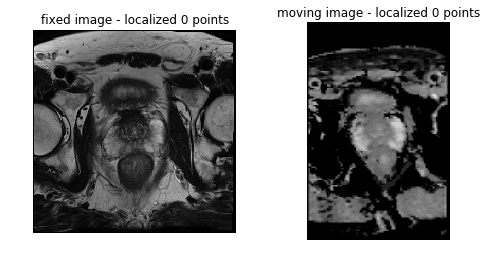

In [9]:
initial_transform = sitk.CenteredTransformInitializer(fixed_image, 
                                                      newimage2, 
                                                      sitk.Euler3DTransform(), 
                                                      sitk.CenteredTransformInitializerFilter.GEOMETRY)

gui.RegistrationPointDataAquisition(newimage1, newimage2, figure_size=(8,4), known_transformation=initial_transform);

# Extraction

In [52]:
patch = get_slice_from_image(newimage1,(40,40,40),(25.7457, 31.8707, -38.0),'t')

(83.39855109133764, 111.79961090623999, 25.978163149699792)
[(104, 64), (132, 92), (46, 6)]
(40, 40, 40)
(40, 40, 40)


In [240]:
patch.shape

(2, 40, 40)

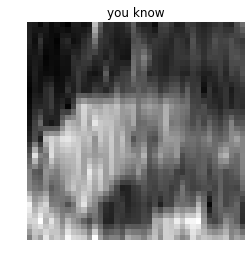

In [243]:
imshow(patch[1])


In [88]:
def imshow(vol,title = "you know"):
    plt.figure()
    plt.imshow(vol, cmap = 'gray')
    plt.axis('off')
    plt.title(title)

# Normalization

In [41]:
fixed_series_filenames = sitk.ImageSeriesReader_GetGDCMSeriesFileNames(ppcs.get_path('ProstateX-0000', 't2tsetra', '../../data/PROSTATEx'))
moving_series_filenames = sitk.ImageSeriesReader_GetGDCMSeriesFileNames(ppcs.get_path('ProstateX-0000', 'adc', '../../data/PROSTATEx'))

fixed_image = sitk.ReadImage(fixed_series_filenames, sitk.sitkFloat32)
moving_image = sitk.ReadImage(moving_series_filenames, sitk.sitkFloat32)

In [42]:
vol = sitk.GetArrayFromImage(fixed_image)

Text(0.5, 1.0, 'Histogram with zero elements')

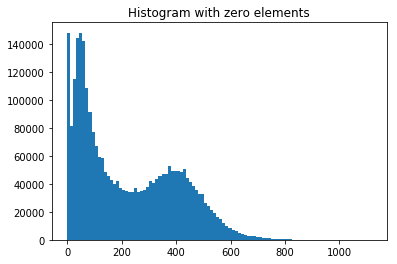

In [46]:
plt.hist(vol.flatten(),bins = 100)
plt.title("Histogram with zero elements")

Text(0.5, 1.0, 'Histogram with no zero elements')

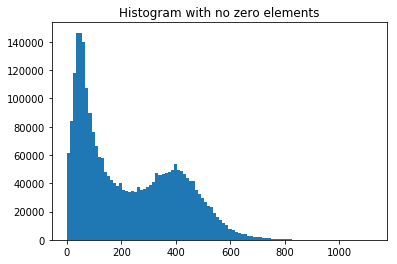

In [47]:
vol_nonzero_voxels = vol[vol>0]
# plt.figure()
plt.hist(vol_nonzero_voxels.flatten(),bins = 100)
plt.title("Histogram with no zero elements")

Text(0.5, 1.0, 'Histogram with normalized elements')

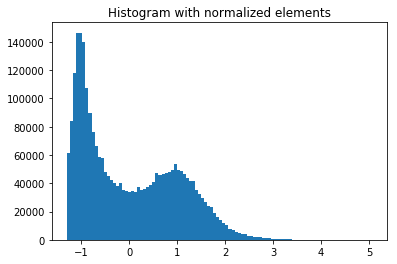

In [48]:
normalized_volume = (vol_nonzero_voxels - vol_nonzero_voxels.mean()) / vol_nonzero_voxels.std()
plt.figure()
plt.hist(normalized_volume.flatten(),bins = 100)
plt.title("Histogram with normalized elements")

In [52]:
def z_score(x,mean,std):
    return (x- mean)/std

Text(0.5, 1.0, 'Histogram with normalized elements')

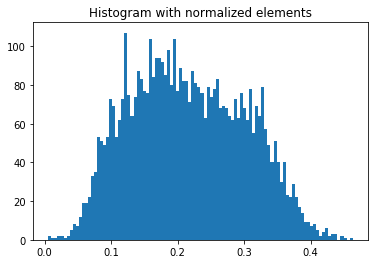

In [55]:
patch  = ppcs.get_patch_from_image(fixed_image,[40,40,3], (25.7457, 31.8707, -38.511))
mina = z_score(vol.min(),vol_nonzero_voxels.mean(),vol_nonzero_voxels.std())
maxi = z_score(vol.max(),vol_nonzero_voxels.mean(),vol_nonzero_voxels.std())

normalized_volume = (((patch - vol_nonzero_voxels.mean()) / vol_nonzero_voxels.std()) - mina) / (maxi - mina)
plt.figure()
plt.hist(normalized_volume.flatten(),bins = 100)
plt.title("Histogram with normalized elements")

In [29]:
def imshow(vol,title:str):
    vol = sitk.GetArrayFromImage(vol)
    plt.figure()
    plt.imshow(vol[len(vol) // 2], cmap = 'gray')
    plt.axis('off')
    plt.title(title)
    
def imshow_slice(vol,slic,title:str):
    vol = sitk.GetArrayFromImage(vol)
    plt.figure()
    plt.imshow(vol[slic], cmap = 'gray')
    plt.axis('off')
    plt.title(title)
    
def show_mid_slice(vol,title):
    plt.imshow(vol[len(vol) // 2], cmap = 'gray')
    plt.axis('off')
    plt.title(title)

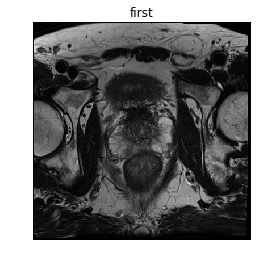

In [15]:
imshow(fixed_image,"first")

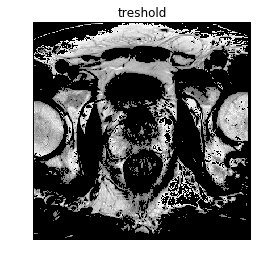

In [18]:
vol_tresholded =  sitk.Threshold(fixed_image,200,500)
imshow(vol_tresholded,"treshold")

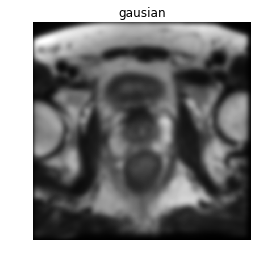

In [19]:
vol_gaussian  = sitk.DiscreteGaussian(fixed_image,5)
imshow(vol_gaussian,"gausian")

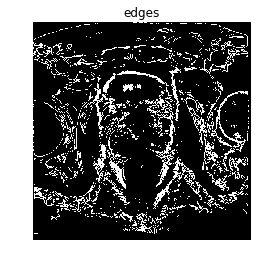

In [30]:

vol_edges = sitk.CannyEdgeDetection(fixed_image, lowerThreshold = 100, upperThreshold=200)
imshow(vol_edges,"edges")

# Load images

In [3]:
patients_names = df_images['ProxID'].unique()
root_path = '../../data/PROSTATEx'
modality = 't2tsetra'
volumes = []
images = []

for patient_name in patients_names:
    
    path_to_image = ppcs.get_path(patient_name, modality, root_path)
    fixed_series_filenames = sitk.ImageSeriesReader_GetGDCMSeriesFileNames(path_to_image)
    image = sitk.ReadImage(fixed_series_filenames)
    images.append(image)
    volume  = sitk.GetArrayFromImage(image)
    volumes.append(volume)
   

In [4]:
gausian = normalization.GaussianNormalisation()

In [39]:
vol = volumes[0]
print(f'''
mean: {vol.mean()}
std: {vol.std()}
min: {vol.min()}
max: {vol.max()}
q25: {np.quantile(vol,0.25)}
q75: {np.quantile(vol,0.75)}
IQR: {np.subtract(*np.quantile(vol,[0.25,0.75]))}
non zero voxel: {np.sum(vol>0) / len(vol.flatten())}
intensity histogram: {list(np.histogram(vol,bins = 20)[0])}
''')


mean: 221.72702615302904
std: 177.77389794138088
min: 0
max: 1118
q25: 61.0
q75: 373.0
IQR: -312.0
non zero voxel: 0.9668489868877924
intensity histogram: [636505, 486759, 254662, 189060, 174779, 199053, 241417, 241929, 180590, 107137, 51355, 21660, 10156, 4357, 1782, 367, 63, 23, 8, 2]



In [6]:
def outliers_iqr(ys):
    quartile_1, quartile_3 = np.percentile(ys, [25, 75])
    iqr = quartile_3 - quartile_1
    lower_bound = quartile_1 - (iqr * 1.5)
    upper_bound = quartile_3 + (iqr * 1.5)
    ys[ys<lower_bound] = lower_bound
    ys[ys>upper_bound] = upper_bound
    return ys

In [5]:
findings.loc[304]

ProxID               ProstateX-0189
fid                               3
pos        8.35175 26.1661 -23.7111
zone                             PZ
ClinSig                       False
Name: 304, dtype: object

# Test preprocessing

In [3]:
root_path = '../../data/PROSTATEx'
path_to_data = '../../data/'
modality = 'adc'
new_spacing = (0.5,0.5,0.5)
orientation = 't'
patch_size = (28,28,1)

target_path = os.path.join(path_to_data, modality, orientation, 
                            str(patch_size[0]) + 'x' + str(patch_size[1]) + 'x' + str(patch_size[2]))
new_df = pd.DataFrame(columns = ['ProxID','fid','zone','ClinSig','name'])
roi_volumes = []
findings = df_findings[df_findings['ProxID'] != 'ProstateX-0025']

# iterate throught all findings
for idx,row in findings.iterrows():
    print(idx)
    path_to_image = ppcs.get_path(row['ProxID'], modality, root_path)
    fixed_series_filenames = sitk.ImageSeriesReader_GetGDCMSeriesFileNames(path_to_image)
    image = sitk.ReadImage(fixed_series_filenames)
    # fit normalizer
    normalizer = normalization.ScaleNormalization()
    normalizer.fit(sitk.GetArrayFromImage(image))
    # resample image to same spacing in all directions
    image = ppcs.resample_image_to_spacing(image, new_spacing, sitk.sitkBSpline)

    # extract region of interest
    center = [float(x) for x in row['pos'].split()] 
    volume  = ppcs.get_patch_from_image(image, patch_size, center, orientation)

    volume = normalizer.normalise(volume)
    
    file_name = row['ProxID']+'_'+str(idx)+'_'+row['zone']+'.nii'
    new_df.loc[idx] = row[['ProxID','fid','zone','ClinSig']]
    new_df.loc[idx,'name'] = file_name
    
#     ppcs.save_image(volume, os.path.join(target_path,file_name))
    
new_df.to_csv(os.path.join(target_path,'info.csv'))

0
Size:(84, 128, 19) to (336, 512, 114), Spacing: (2.0, 2.0, 3.0000007152557373) to (0.5, 0.5, 0.5)
1
Size:(84, 128, 19) to (336, 512, 114), Spacing: (2.0, 2.0, 2.9999988079071045) to (0.5, 0.5, 0.5)
2
Size:(84, 128, 19) to (336, 512, 114), Spacing: (2.0, 2.0, 3.0000016689300537) to (0.5, 0.5, 0.5)
3
Size:(84, 128, 19) to (336, 512, 114), Spacing: (2.0, 2.0, 3.0000016689300537) to (0.5, 0.5, 0.5)
4
Size:(84, 128, 19) to (336, 512, 114), Spacing: (2.0, 2.0, 3.000000476837158) to (0.5, 0.5, 0.5)
5
Size:(84, 128, 19) to (336, 512, 114), Spacing: (2.0, 2.0, 3.000000476837158) to (0.5, 0.5, 0.5)
6
Size:(84, 128, 19) to (336, 512, 171), Spacing: (2.0, 2.0, 4.500001430511475) to (0.5, 0.5, 0.5)
7
Size:(84, 128, 19) to (336, 512, 114), Spacing: (2.0, 2.0, 3.0000009536743164) to (0.5, 0.5, 0.5)
8
Size:(84, 128, 19) to (336, 512, 114), Spacing: (2.0, 2.0, 3.0000009536743164) to (0.5, 0.5, 0.5)
9
Size:(84, 128, 19) to (336, 512, 114), Spacing: (2.0, 2.0, 3.0000009536743164) to (0.5, 0.5, 0.5)
10


Exception: Boundaries out of image!

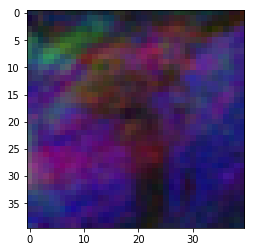

In [65]:
plt.imshow(rgba)

Text(0.5, 1.0, 'Histogram with normalized elements')

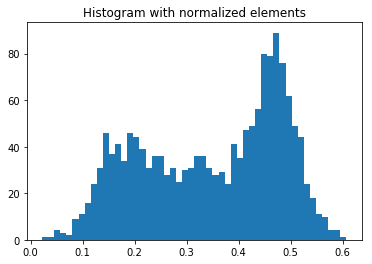

In [26]:
plt.figure()
plt.hist(roi_volumes[2].flatten(),bins = 50)
plt.title("Histogram with normalized elements")

In [12]:
histograms = [None] * len(roi_volumes)
for idx,volume in enumerate (roi_volumes):
    volume = volume[volume > 0]
    hist = np.histogram(volume,100)[0]
    histograms[idx] = hist
histograms = np.array(histograms)

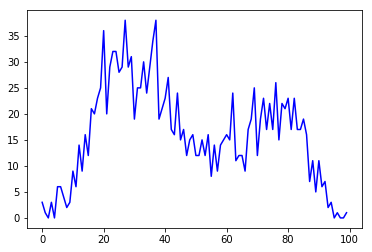

In [13]:
plt.plot(np.arange(100),histograms[3], 'b')

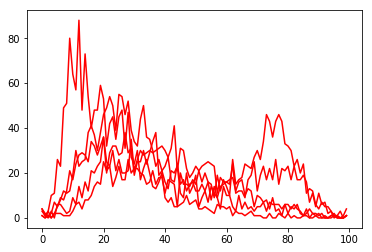

In [20]:
for ad in histograms:
    plt.plot(np.arange(100),ad, 'r')

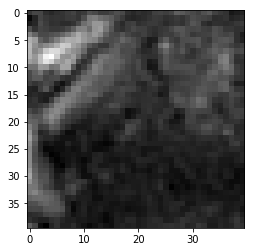

In [22]:
plt.imshow(roi_volumes[1],cmap = 'gray')

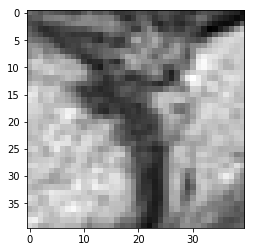

In [28]:
plt.imshow(roi_volumes[2],cmap = 'gray')

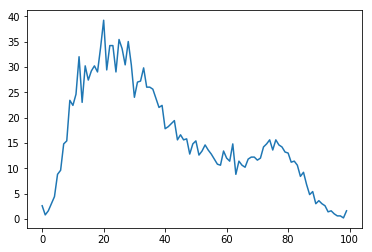

In [23]:
average_histogram = histograms.mean(axis = 0)
plt.figure()
plt.plot(np.arange(100),average_histogram)

## Intensities of ROIs from volumes

In [55]:
root_path = '../../data/PROSTATEx'
modality = 't2tsetra'
roi_volumes = []
findings = df_findings[df_findings['ProxID'] != 'ProstateX-0025']
for row in findings.iterrows():
    print(row[1]['ProxID'])
    path_to_image = ppcs.get_path(row[1]['ProxID'], modality, root_path)
    fixed_series_filenames = sitk.ImageSeriesReader_GetGDCMSeriesFileNames(path_to_image)
    image = sitk.ReadImage(fixed_series_filenames)
    center = [float(x) for x in row[1]['pos'].split()] 
    print(center)
    volume  = ppcs.get_patch_from_image(image,[40,40,3], center)
    roi_volumes.append(volume)

In [33]:
roi_volumes[0].shape

(3, 40, 40)

In [56]:
histograms = [None] * len(roi_volumes)
for idx,volume in enumerate(roi_volumes):
    volume = volume[volume > 0]
    hist = np.histogram(volume,100)[0]
    histograms[idx] = hist
histograms = np.array(histograms)

In [57]:
histograms.shape

(325, 100)

In [58]:
cn_histograms = histograms[findings['ClinSig'] == True]
ad_histograms = histograms[findings['ClinSig'] == False]

# assert len(cn_histograms) == len(ad_histograms) == 10, "should be 325"

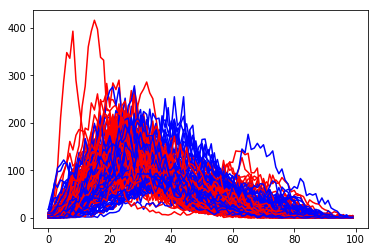

In [59]:
for cn,ad in zip(cn_histograms,ad_histograms):
    plt.plot(np.arange(100),cn, 'r')
    plt.plot(np.arange(100),ad, 'b')

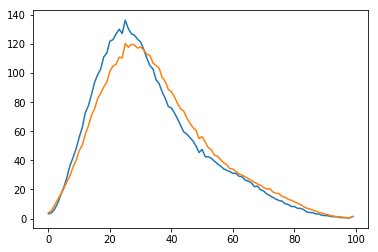

In [60]:
average_cn_histogram = cn_histograms.mean(axis = 0)
average_ad_histogram = ad_histograms.mean(axis = 0)

plt.figure()
plt.plot(np.arange(100),average_cn_histogram)
plt.plot(np.arange(100),average_ad_histogram)

In [64]:
normalized_volumes = []
for volume in roi_volumes: 
    volume = volume[volume > 0]
    normalized_volume = (volume - volume.mean()) / volume.std()
    normalized_volume = (normalized_volume - normalized_volume.min()) / (normalized_volume.max()-normalized_volume.min())
    normalized_volumes.append(normalized_volume)

In [65]:
histograms = [None] * len(normalized_volumes)
for idx,volume in enumerate(normalized_volumes):
    hist = np.histogram(volume,100)[0]
    histograms[idx] = hist
histograms = np.array(histograms)

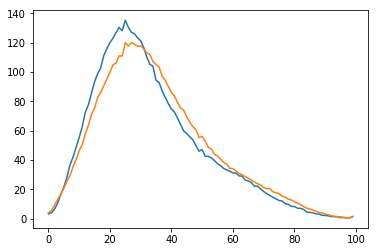

In [66]:
cn_histograms = histograms[findings['ClinSig'] == True]
ad_histograms = histograms[findings['ClinSig'] == False]
average_cn_histogram = cn_histograms.mean(axis = 0)
average_ad_histogram = ad_histograms.mean(axis = 0)

plt.figure()
plt.plot(np.arange(100),average_cn_histogram)
plt.plot(np.arange(100),average_ad_histogram)

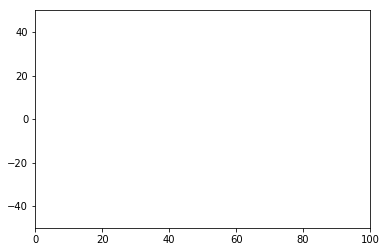

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [19]:
import matplotlib.pyplot as plt
import time
import random
 
ysample = random.sample(range(-50, 50), 100)
 
xdata = []
ydata = []
 
plt.show()
 
axes = plt.gca()
axes.set_xlim(0, 100)
axes.set_ylim(-50, +50)
line, = axes.plot(xdata, ydata, 'r-')
 
for i in range(100):
    xdata.append(i)
    ydata.append(ysample[i])
    line.set_xdata(xdata)
    line.set_ydata(ydata)
    plt.draw()
    plt.pause(1e-17)
    time.sleep(0.1)
    
plt.show()